# 2 Model Train
- 使用CV方法做训练

In [14]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Concatenate, Attention
from tensorflow.keras.callbacks import ModelCheckpoint

In [15]:
DATA_PATH = "data_add_train.json"
def load_data(data_path):
    """Loads training dataset from json file
    
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)
        
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def prepare_datasets(test_size, validation_size):
    
    # load data
    X, y = load_data(DATA_PATH)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = validation_size)
    
    return (X_train, X_validation, X_test, y_train, y_validation, y_test)

    
def plot_history(history):
    
    fig, axs = plt.subplots(2)
    plt.figure(dpi=450)
    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label = "train accuracy")
    axs[0].plot(history.history["val_accuracy"], label = "test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc = "lower right")
    axs[0].set_title("Accuracy eval")
    
    # create accuracy subplot
    axs[1].plot(history.history["loss"], label = "train error")
    axs[1].plot(history.history["val_loss"], label = "test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc = "upper right")
    axs[1].set_title("Error eval")
    
    plt.show()
    
def predict(model, X, y):
    
    X = X[np.newaxis, ...]
    
    # prediction = [ [0.1, 0.2, ...]]
    prediction = model.predict(X) # X -> (1, 130, 13, 1)
    
    # extract index with max value
    predicted_index = np.argmax(prediction, axis = 1) #[4]
    print("Expected index: {}, Predicted index: {}".format(y,  predicted_index))

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

# Transformer块
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# 构建模型
class TransformerModel(tf.keras.Model):
    def __init__(self, embed_dim, num_heads, ff_dim, num_classes, dropout_rate):
        super(TransformerModel, self).__init__()
        self.input_projection = layers.Dense(embed_dim)  # 使用全连接层来调整输入维度
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate) 
                                   for _ in range(2)]
        self.global_average = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout_rate)
        self.out = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs, training):
        x = self.input_projection(inputs)  # 调整输入维度
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training)
        x = self.global_average(x)  # 平均池化
        x = self.dropout(x, training)
        return self.out(x)

# # 实例化模型
# model = TransformerModel(embed_dim, num_heads, ff_dim, num_classes, dropout_rate)

# # 编译模型
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# # 打印模型结构
# model.build(input_shape=(None, 130, 13))
# model.summary()


In [17]:
def build_model():
    """
    Generates RNN-LSTM model
    
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """
    # 参数设置
    embed_dim = 64  # 嵌入维度
    num_heads = 4    # 多头注意力的头数
    ff_dim = 256     # 前馈神经网络的维度
    num_classes = 2 # 分类类别数，根据实际数据集调整
    dropout_rate = 0 # Dropout比率
    # 实例化模型
    model = TransformerModel(embed_dim, num_heads, ff_dim, num_classes, dropout_rate)

    return model

(44, 13)
Model: "transformer_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             multiple                  896       
                                                                 
 transformer_block_2 (Transf  multiple                 99712     
 ormerBlock)                                                     
                                                                 
 transformer_block_3 (Transf  multiple                 99712     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   multiple                 0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                      

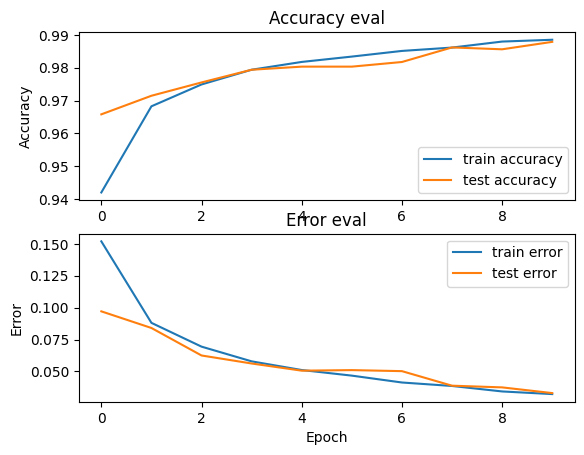

<Figure size 2880x2160 with 0 Axes>

In [10]:
if __name__ == "__main__":
    
    # create train, validation and test sets
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.2, 0.05)
    model = build_model()
    
    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
    model.build(input_shape=(None, 44, 13))
    model.summary()
    

    history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), batch_size = 32, epochs = 10)
    
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
    print("Accuracy on test set is: {}".format(test_accuracy))
    
    # make prediction on a sample
    X = X_test[0]
    y = y_test[0]

    predict(model, X, y)
    
    # plot accuracy and error over the epochs
    plot_history(history)

In [11]:
model.save_weights('02_model/Transformer-mini.h5')

In [19]:
model = build_model()
model.build(input_shape=(None, 44, 13))
model.load_weights('02_model/Transformer-mini.h5')

In [12]:
X_test_pre = model.predict(X_test)
y_pre = np.argmax(X_test_pre, axis = 1)

import sklearn.metrics as sm
matrixes = sm.confusion_matrix(y_test, y_pre)
print(matrixes)
report = sm.classification_report(y_test, y_pre)
print(report)

1660/1660 [==============================] - 8s 5ms/step
[[43613   246]
 [  431  8800]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43859
           1       0.97      0.95      0.96      9231

    accuracy                           0.99     53090
   macro avg       0.98      0.97      0.98     53090
weighted avg       0.99      0.99      0.99     53090



In [13]:
X_dev, y_dev = load_data("data_add_test.json")
y_dev_pre = np.argmax(model.predict(X_dev), axis = 1)
matrixes = sm.confusion_matrix(y_dev, y_dev_pre)
print(matrixes)
report = sm.classification_report(y_dev, y_dev_pre)
print(report)

8296/8296 [==============================] - 41s 5ms/step
[[218429    907]
 [  1627  44487]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    219336
           1       0.98      0.96      0.97     46114

    accuracy                           0.99    265450
   macro avg       0.99      0.98      0.98    265450
weighted avg       0.99      0.99      0.99    265450

